In [ ]:
## Refraction: prism

In this section, we explore refraction using a prism rather than a lens <a href="https://opticsf2f.github.io/Opticsf2f_CodeBook/LensRefraction.html">
refraction by a lens, LensRefraction.ipynb</a>. Note that, as previously, the propagation code is paraxial so we can expect significant errors
when the angle between the propagation direction and the surface normal is greater than about 30 degrees.

In terms of physics, refraction by a prism is simpler because there is only one angle of incidence.

In terms of the core of the code, they are the same.

<iframe src="PrismInteractive.html" title="Interactive Prism Tutorial" height = 600> </iframe> 

Next, we present the code.

The Jupyter Notebook is PrismRefraction.ipynb see

https://github.com/opticsf2f/Opticsf2f_CodeBook

<div class="interactive-start" onclick="initInteractiveCode()" title="This runs Python in your browser, allowing you local calculations">CLICK HERE TO ACTIVATE CODE CELLS</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from numpy.fft import fft, ifft, fftshift

This cell defines a few functions. We shall use Line for rays and Triangle for a prism.

In [2]:
def Rectangle(x,y,x0,y0,a,b,rotation):
    xa = (x-x0)*np.cos(rotation) + (y-y0)*np.sin(rotation)
    ya = (y-y0)*np.cos(rotation) - (x-x0)*np.sin(rotation)
    return (xa > (-a/2)) & (xa < (a/2)) & (ya > (-b/2)) & (ya < (b/2))

def Line(x,y,x1,y1,x2,y2,a):
    x0 = x1
    y0 = y1
    b = np.sqrt((x1-x2)**2 + (y1-y2)**2) # length of line
    rotation = -np.arctan((x2-x1)/(y2-y1))
    xa = (x-x0)*np.cos(rotation) + (y-y0)*np.sin(rotation)
    ya = (y-y0)*np.cos(rotation) - (x-x0)*np.sin(rotation)
    return (xa > (-a/2)) & (xa < (a/2)) & (ya > (0)) & (ya < (b))

def GBeam(zb,yb,z0,y0,beamsize,angle):
    angle = angle
    za = (zb-z0)*np.cos(angle) + (yb-y0)*np.sin(angle)
    ya = (yb-y0)*np.cos(angle) - (zb-z0)*np.sin(angle)
    zR = np.pi*beamsize**2
    q = za-1.j*zR
    return (-1.j*zR*np.exp(2*np.pi*1.j*(za+ya*ya/(2*q)))/q) 

def Ray(zb,yb,z0,y0,beamsize,angle):
    angle = angle
    za = (zb-z0)*np.cos(angle) + (yb-y0)*np.sin(angle)
    ya = (yb-y0)*np.cos(angle) - (zb-z0)*np.sin(angle)
    return (np.exp(2*np.pi*1.j*za-(ya/beamsize)**2))

def Triangle(x,y,x0,y0,size,angle):
    return ((-y-y0 + size/(2*np.cos(angle/2))-np.tan(angle)*(x-x0) > (0)) 
            &  (-y-y0 + size/(2*np.cos(angle/2))+np.tan(angle)*(x-x0) > (0)) 
            & (-y-y0 + size/(2*np.cos(angle/2)) < (size*np.cos(angle/2))))

def Circle(x,y,x0,y0,r):
    xa = x-x0
    ya = y-y0
    return (xa*xa + ya*ya < (r*r)) 

Next we define a grid in units of the wavelength. $dy$ and $dz$ are the spatial resolution. 
$\lambda/50$ for the values given below.

In [3]:
zmin = 0 # z is the horizontal axis so like x in cartesian system
zmax = 20
ymin = -8   # vertical axis coould be x or y, call it y to agree with standard axes
ymax = 12
dz = 0.02
dy = 0.02
zoom = 1
Z, Y = np.mgrid[zmin/zoom:zmax/zoom:dz/zoom,ymin/zoom:ymax/zoom:dy/zoom]
z_pts, y_pts = np.shape(Z)

This is the $k$-space grid.

In [4]:
kymax=1.0*np.pi/dy 
dky=2*kymax/y_pts
ky=np.arange(-kymax,kymax,dky) # fourier axis scaling
ky2=ky*ky
ky2c=ky2.astype('complex') #Notes on complex types http://www.scipy.org/NegativeSquareRoot
k=2.0*np.pi # k=2pi/lambda with lambda_0=1
k2=k*k
kz=np.sqrt(k2-ky2c)

This is the propagation phase the appear in the hedgehog equation.

In [5]:
ph=1.0j*kz*dz

We define triangle that will become our prism

In [6]:
PSize = 18
PAngle = 60*np.pi/180
PCentre = PSize/(2*np.cos(PAngle/2))
PWidth = PSize*np.sin(PAngle/2)
Prism = Triangle(Z,Y,zmax/2,0,PSize,PAngle)

This cell defines the parameter of the plot. The refractive index of the prism. The input beam size and propagation
angle.

In [7]:
Index = 1.5

BeamSize = 3
BAngle = 20*np.pi/180
BeamOffset = 0

The next cell creates the image. The first few lines initialise the RGB grid, then we add the prism 
and a gaussian beam in the input plane. The hedgehog equation propagation propagates the field
Next we add the result, either the electric field or the intensity into the RGB channels.

The rest of the code is to add rays. 

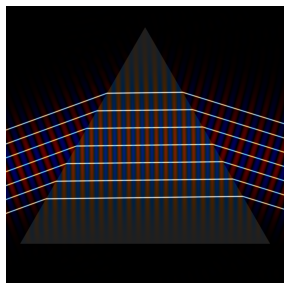

In [8]:
E_or_I = "Field"
Rays = "Rays"

R = np.zeros((z_pts,y_pts))
G = np.zeros((z_pts,y_pts))
B = np.zeros((z_pts,y_pts))

NR = np.zeros((z_pts,y_pts))# refractive index
NR += (Index-1)*Prism 

E0 = GBeam(Z[0,:],Y[0,:],0,BeamOffset,BeamSize,BAngle)

b = fftshift(fft(E0))
for jj in range (0,z_pts): # propagat
        c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NR[jj,:]*dz)
        b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
        if (E_or_I == "Field"):
            R[jj,:] +=  0.4*c.real
            B[jj,:] -=  0.4*c.real
        if (E_or_I == "Intensity"):
            G[jj,:] +=  0.2*(abs(c)*abs(c))**0.5

fig, (ax1) = plt.subplots(1,1,figsize=(6, 6),dpi=60)

if (Rays == "Rays"):
    for RayDisp in range (-3,4,1):
        BeamOff = 0
        ZR1 = 0
        YR1 = BeamOffset + RayDisp
        ZR2 = ( - PCentre + YR1 + zmax/2*np.tan(PAngle) - ZR1*np.tan(BAngle))/(np.tan(PAngle)-np.tan(BAngle))
        YR2 = YR1 + (ZR2 - ZR1) * np.tan(BAngle) # eqn or incomping ray
        Theta_i = np.pi/2 - PAngle + BAngle
        Theta_t = np.arcsin(1/Index*np.sin(Theta_i))
        BAngle2 =  - (np.pi/2 - PAngle) + Theta_t  
        ZR3 = ( - PCentre + YR2 + zmax/2*np.tan(-PAngle) - ZR2*np.tan(BAngle2))/(np.tan(-PAngle)-np.tan(BAngle2))
        YR3 = YR2 + (ZR3 - ZR2) * np.tan(BAngle2) # eqn or incomping ray
        Theta_i = np.pi/2 + PAngle + BAngle2
        Theta_t = np.arcsin(Index*np.sin(Theta_i))
        BAngle3 =  - (np.pi/2 - PAngle) + Theta_t
        ZR4 = zmax
        YR4 = YR3 - (ZR4 - ZR3) * np.tan(BAngle3) # eqn or incomping ray
        RayBefore = (-Y + PCentre + np.tan(PAngle)*(Z-zmax/2) < (0)) 
        RayInside = ((-Y + PCentre + np.tan(PAngle)*(Z-zmax/2) > (0)) 
                     & (-Y + PCentre - np.tan(PAngle)*(Z-zmax/2) > (0)))
        RayAfter = (-Y + PCentre - np.tan(PAngle)*(Z-zmax/2) < (0))

        R1 = Ray(Z,Y,ZR1,YR1,0.05,BAngle) * RayBefore
        Intensity = R1.real * R1.real + R1.imag * R1.imag
        R += Intensity
        G += Intensity
        B += Intensity
        R2 = Ray(Z,Y,ZR2,YR2,0.05,BAngle2) * RayInside
        Intensity = R2.real * R2.real + R2.imag * R2.imag
        R += Intensity
        G += Intensity
        B += Intensity
        R3 = Ray(Z,Y,ZR3,YR3,0.05,-BAngle3) * RayAfter
        Intensity = R3.real * R3.real + R3.imag * R3.imag
        R += Intensity
        G += Intensity
        B += Intensity

R+=0.25*(Index-1)*Prism # add prism to final image
G+=0.25*(Index-1)*Prism
B+=0.25*(Index-1)*Prism

br=1.0 
bg=1.0 
bb=1.0 

R=np.clip(br*R,0.0,1.0)
G=np.clip(bg*G,0.0,1.0)
B=np.clip(bb*B,0.0,1.0)
RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left

ax1.imshow(RGB)
ax1.set_axis_off()
